In [1]:
import plot
from shap.maskers import Independent
import shap
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import pickle
%matplotlib inline
shap.initjs()

In [2]:
with open('dataset.pickle', 'rb') as f:
    X, y, display_data = pickle.load(f)
with open('classifiers.pickle', 'rb') as f:
    clf_a, clf_b = pickle.load(f)
with open('subsets.pickle', 'rb') as f:
    is_pred_diff, is_pred_diff_a_pos, is_pred_diff_b_pos, is_high_proba_diff, is_low_proba_diff = pickle.load(f)
with open('dataset.explain.pickle', 'rb') as f:
    background_data, X_explain, display_data_explain, is_pred_diff, is_pred_diff_a_pos, is_pred_diff_b_pos, is_high_proba_diff, is_low_proba_diff = pickle.load(f)

In [3]:
try:
    with open('shapvalues.log_odds.pickle', 'rb') as f:
        shap_log_odds_diff, shap_log_odds_diff_a_pos, shap_log_odds_diff_b_pos, overall_importance, feature_order, shap_log_odds_diff_a_vs_b_pos = pickle.load(f)
        print('Loaded cached shap values')
except FileNotFoundError:
    print('No cached shap values found')

Loaded cached shap values


In [3]:
feature_names = np.array(X.columns)
n_features = len(feature_names)
n_samples = X.shape[0]

Now we define the difference functions to be explained:

In [4]:
log_proba_add = lambda y1, y2: y1 + np.log1p(np.exp(y2 - y1))
log_proba_complement = lambda y: np.log1p(-np.exp(y))
log_proba_to_log_odds = lambda x: x - log_proba_complement(x)
merge_log_proba_diff_c1_pos = lambda y1, y2: y1[:, 1] + y2[:, 0]
predict_log_odds_diff_a_pos = lambda X: log_proba_to_log_odds(merge_log_proba_diff_c1_pos(clf_a.predict_log_proba(X), clf_b.predict_log_proba(X)))
predict_log_odds_diff_b_pos = lambda X: log_proba_to_log_odds(merge_log_proba_diff_c1_pos(clf_b.predict_log_proba(X), clf_a.predict_log_proba(X)))

In [5]:
merge_log_proba_diff = lambda y1, y2: log_proba_add(merge_log_proba_diff_c1_pos(y1, y2), merge_log_proba_diff_c1_pos(y2, y1))
predict_log_odds_diff = lambda X: log_proba_to_log_odds(merge_log_proba_diff(clf_a.predict_log_proba(X), clf_b.predict_log_proba(X)))

And now we calculate SHAP values for each merge function:

In [6]:
def explain(predict, background_data):
    masker = Independent(data=background_data)
    explainer = shap.Explainer(predict, masker, feature_names=feature_names)
    shap_values = explainer(X_explain)
    shap_values.display_data = display_data_explain
    return shap_values

In [7]:
%%time
shap_log_odds_diff = explain(predict_log_odds_diff, background_data)
shap_log_odds_diff_a_pos = explain(predict_log_odds_diff_a_pos, background_data)
shap_log_odds_diff_b_pos = explain(predict_log_odds_diff_b_pos, background_data)

shap_log_odds_diff_a_vs_b_pos = shap_log_odds_diff_b_pos - shap_log_odds_diff_a_pos
shap_log_odds_diff_a_vs_b_pos.data = shap_log_odds_diff_a_pos.data
shap_log_odds_diff_a_vs_b_pos.display_data = shap_log_odds_diff_a_pos.display_data

is_finite = np.all(np.isfinite(shap_log_odds_diff.values), axis=1)
is_outlier = np.any(shap_log_odds_diff.abs.values > 12, axis=1)
is_normal = is_finite & ~is_outlier
# TODO cache

overall_importance = shap_log_odds_diff[is_normal].abs.mean(axis=0)
feature_order = np.flip(overall_importance.values.argsort())

with open(f'shapvalues.log_odds.pickle', 'wb') as f:
    pickle.dump((shap_log_odds_diff, shap_log_odds_diff_a_pos, shap_log_odds_diff_b_pos, overall_importance, feature_order, shap_log_odds_diff_a_vs_b_pos), f, pickle.HIGHEST_PROTOCOL)

Permutation explainer: 727it [00:38, 15.13it/s]                         
Permutation explainer: 727it [00:35, 14.69it/s]                         
Permutation explainer: 727it [00:40, 13.83it/s]                         


CPU times: user 3min 3s, sys: 16.5 s, total: 3min 19s
Wall time: 1min 54s


## Analyze

### Feature Importance

We estimate it with the mean absolute SHAP value (which is the default for this plot) and will also sort features subsequently in this order

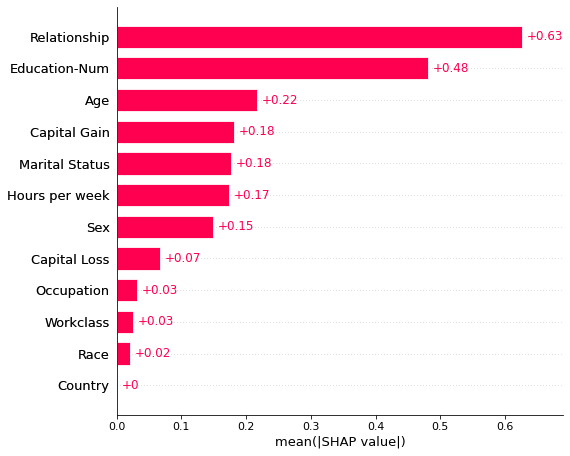

In [8]:
shap.plots.bar(overall_importance, max_display=n_features)

We see, that compared to the overall importance in the lower segment both Relationship and Education-Num are more important while in the higher difference probability segment these probabilities decrease and decrease even further for the actual different subset

TODO: custom bar chart where the ubsets are shown in one plot with multiple bars per feature to allow comparison

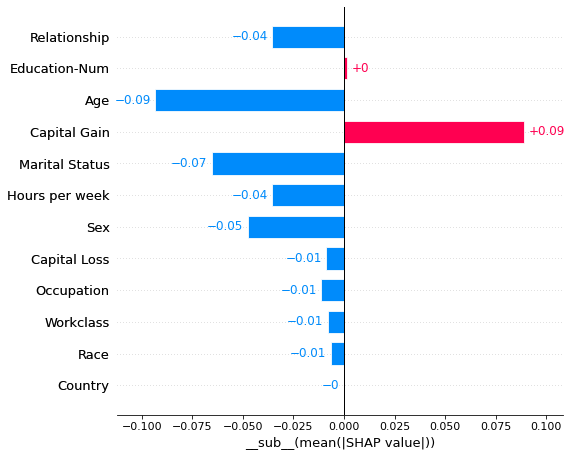

In [29]:
shap.plots.bar(overall_importance - shap_log_odds_diff[is_normal & is_low_proba_diff].abs.mean(0), order=feature_order, max_display=n_features)

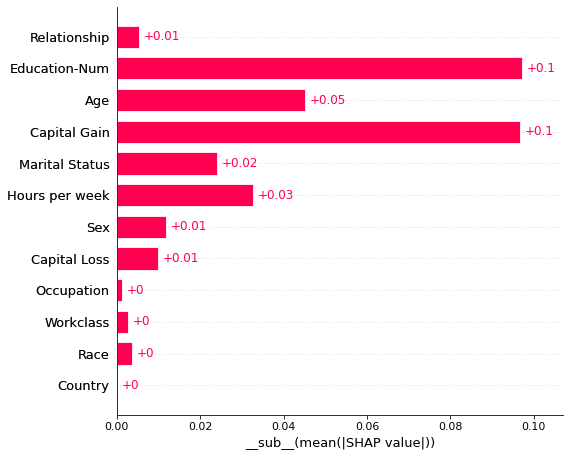

In [30]:
shap.plots.bar(overall_importance - shap_log_odds_diff[is_normal & is_high_proba_diff].abs.mean(0), order=feature_order, max_display=n_features)

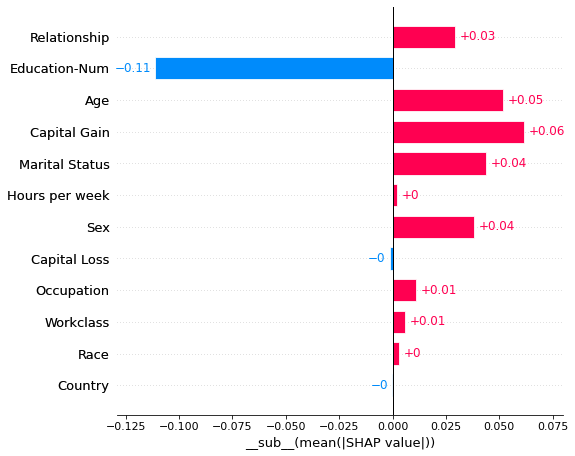

In [31]:
shap.plots.bar(overall_importance - shap_log_odds_diff[is_normal & is_pred_diff].abs.mean(0), order=feature_order, max_display=n_features)

There is actually a significant difference in the two error classes: Capital Gain is more important for B to predict the positive label than for A to predict the positive label

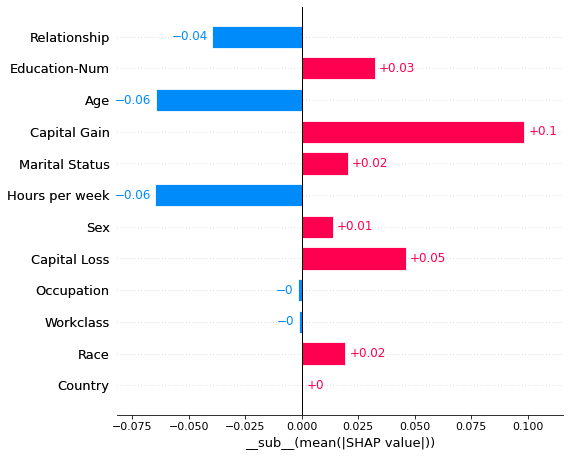

In [32]:
shap.plots.bar(shap_log_odds_diff[is_normal & is_pred_diff_b_pos].abs.mean(0) - shap_log_odds_diff[is_normal & is_pred_diff_a_pos].abs.mean(0), order=feature_order, max_display=n_features)

But we cannot confirm this completely by looking at the importance differences of the separate difference models 

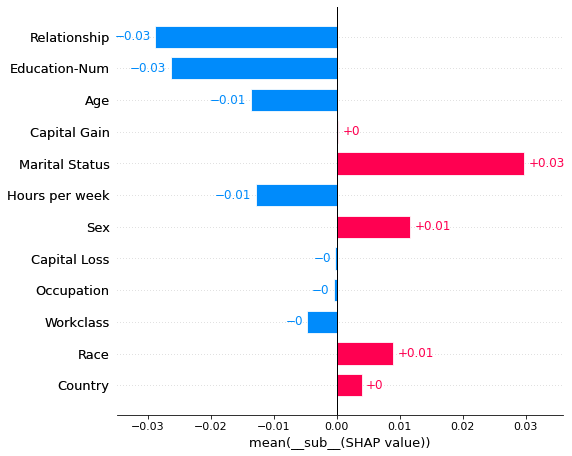

In [33]:
shap.plots.bar(shap_log_odds_diff_a_vs_b_pos[is_normal & (is_high_proba_diff | is_pred_diff)].mean(0), order=feature_order, max_display=n_features)

### SHAP Value Distribution

Next, we will try to understand the importances using the whole distribution of values, not only the aggregated mean.

TODO: build own plots, where all sets of instances are in one plot, with different colors per set and a color range from low to high feature value as well

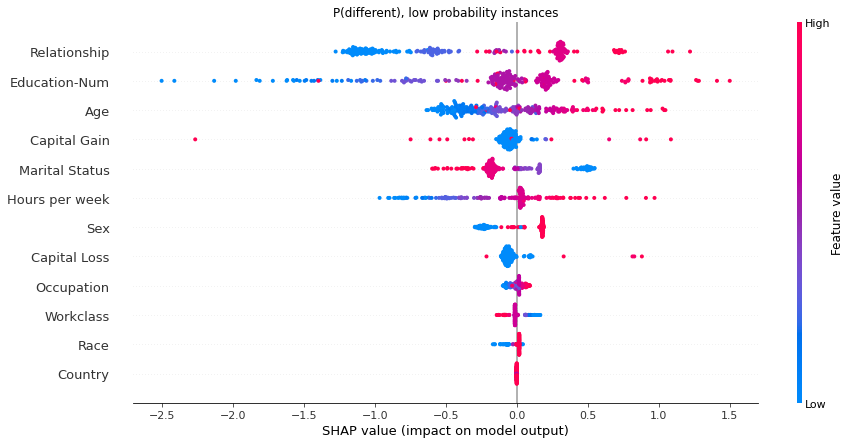

In [34]:
plot.shap_beeswarm(shap_log_odds_diff[is_normal & is_low_proba_diff], 'P(different), low probability instances', order=feature_order, max_display=n_features)

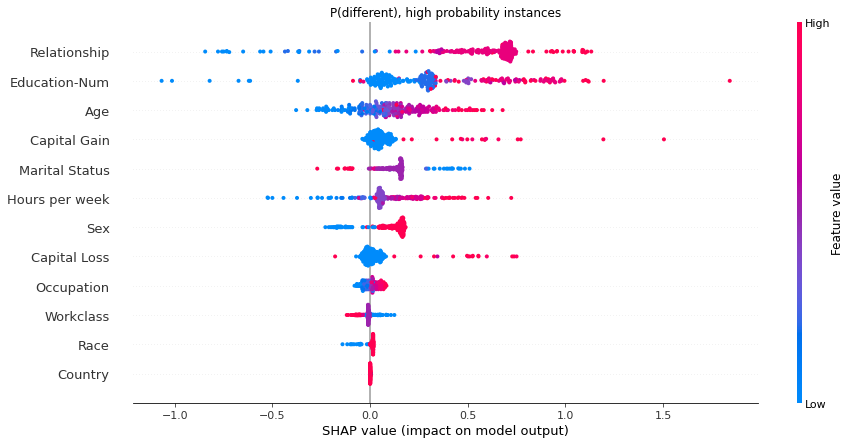

In [36]:
plot.shap_beeswarm(shap_log_odds_diff[is_normal & is_high_proba_diff], 'P(different), high probability instances', order=feature_order, max_display=n_features)

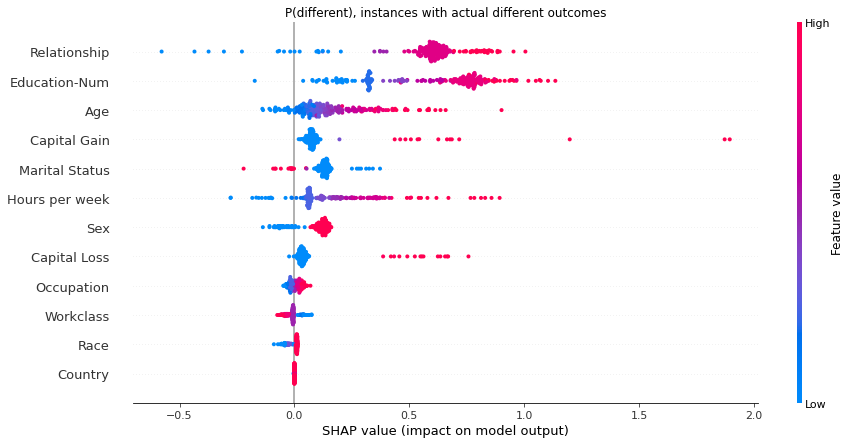

In [37]:
plot.shap_beeswarm(shap_log_odds_diff[is_normal & is_pred_diff], 'P(different), instances with actual different outcomes', order=feature_order, max_display=n_features)

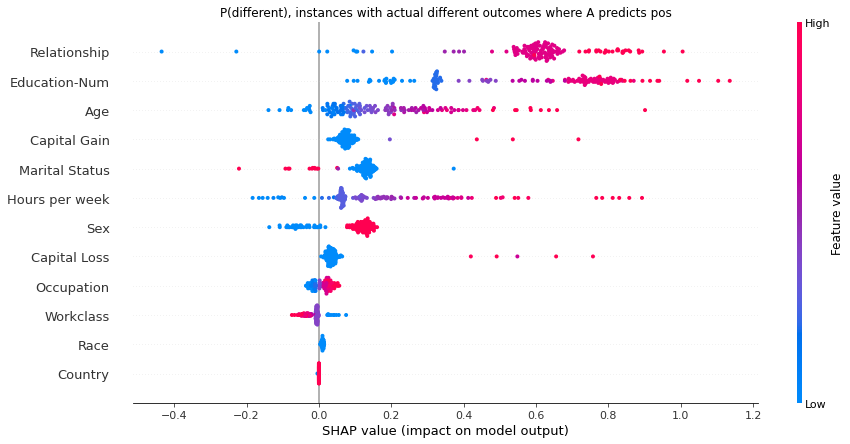

In [38]:
plot.shap_beeswarm(shap_log_odds_diff[is_normal & is_pred_diff_a_pos], 'P(different), instances with actual different outcomes where A predicts pos', order=feature_order, max_display=n_features)

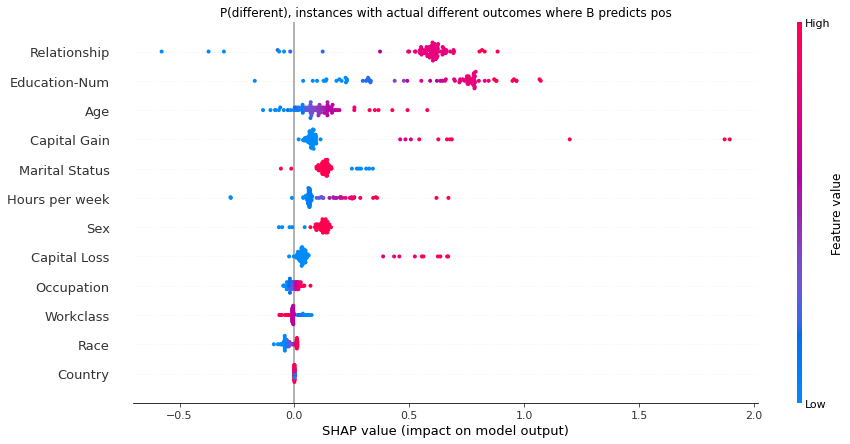

In [39]:
plot.shap_beeswarm(shap_log_odds_diff[is_normal & is_pred_diff_b_pos], 'P(different), instances with actual different outcomes where B predicts pos', order=feature_order, max_display=n_features)

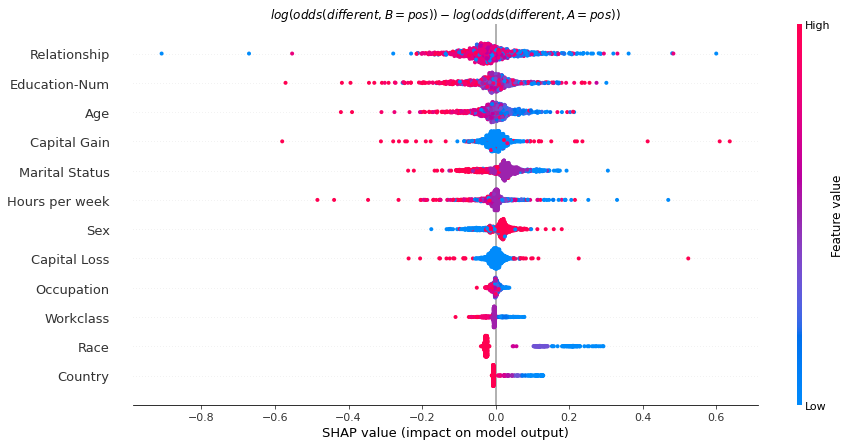

In [40]:
plot.shap_beeswarm(shap_log_odds_diff_a_vs_b_pos[is_normal], '$log(odds(different, B=pos)) - log(odds(different, A=pos))$', order=feature_order, max_display=n_features)

### Features' Partial Dependence Plots

Passing the fontdict parameter of _set_ticklabels() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.


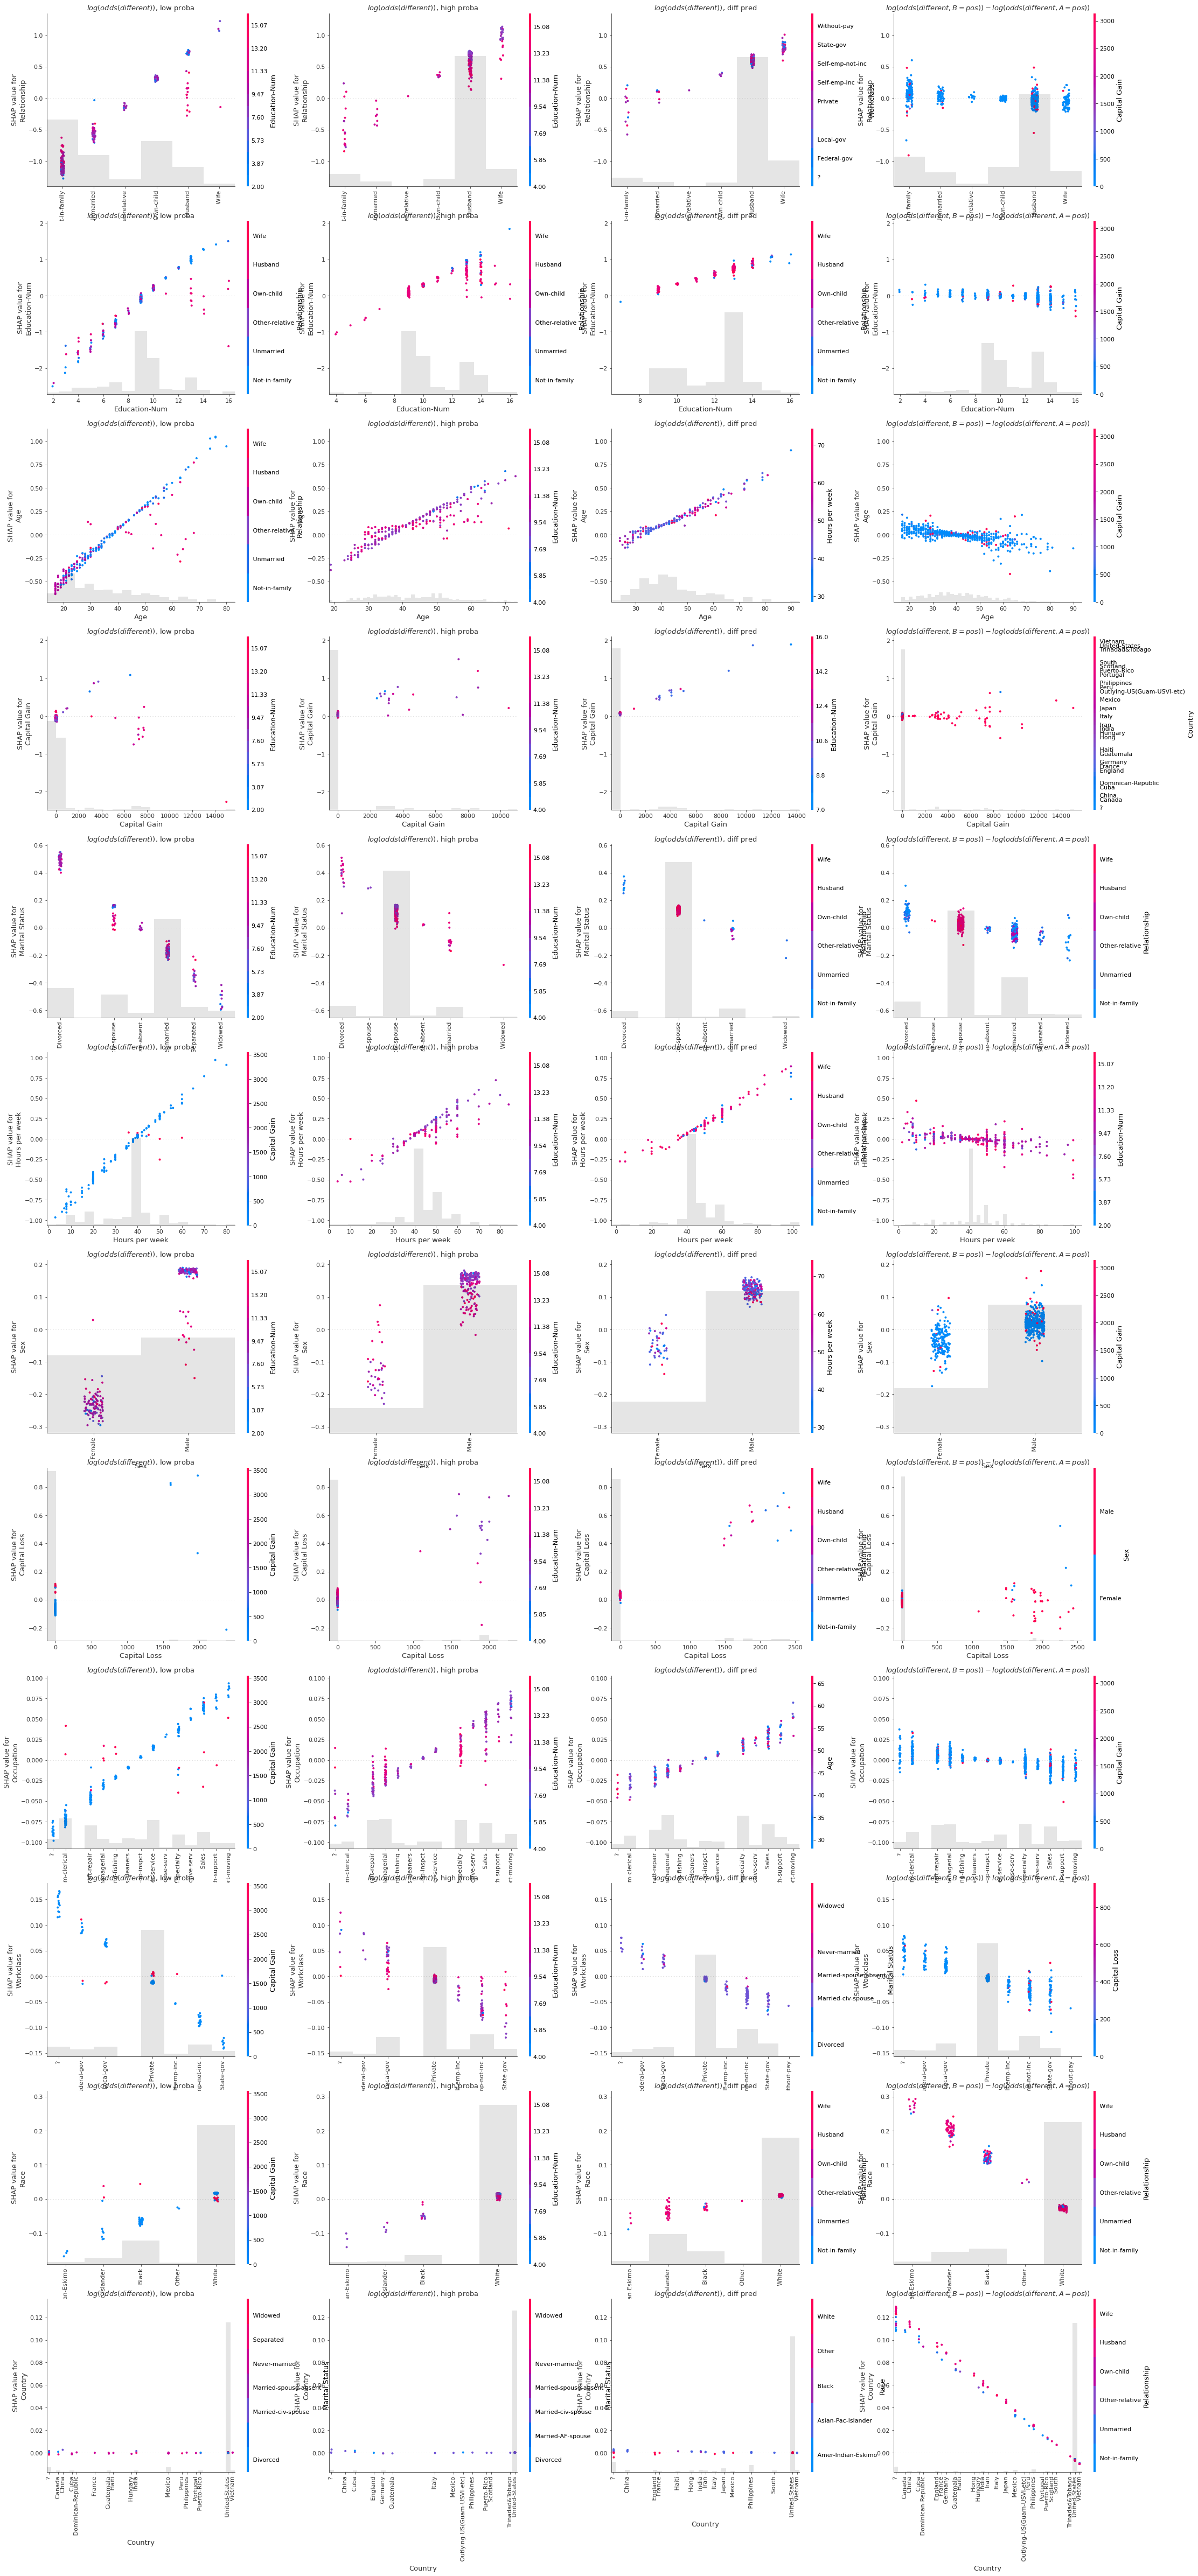

In [41]:
n_columns = 4
n_rows = n_features
fig = plt.figure(figsize=(9*n_columns, 7*n_rows))
i = 1
for feature in feature_names[feature_order]:
    ax = fig.add_subplot(n_rows, n_columns, i)
    plot.shap_scatter(shap_log_odds_diff[is_normal & is_low_proba_diff], feature, '$log(odds(different))$, low proba', ax=ax)
    plot.shap_scatter(shap_log_odds_diff[is_normal & is_high_proba_diff], feature, '$log(odds(different))$, high proba', ax=fig.add_subplot(n_rows, n_columns, i+1, sharey=ax))
    plot.shap_scatter(shap_log_odds_diff[is_normal & is_pred_diff], feature, '$log(odds(different))$, diff pred', ax=fig.add_subplot(n_rows, n_columns, i+2, sharey=ax))
    plot.shap_scatter(shap_log_odds_diff_a_vs_b_pos[is_normal], feature, '$log(odds(different, B=pos)) - log(odds(different, A=pos))$', ax=fig.add_subplot(n_rows, n_columns, i+3, sharey=ax))
    i += n_columns
plt.show()

### Stacked SHAP Explanations, Clustered by Similarity

In [42]:
plot.shap_force(shap_log_odds_diff[is_normal & is_low_proba_diff], 'low probability for difference')
plot.shap_force(shap_log_odds_diff[is_normal & is_high_proba_diff], 'high probability for difference')
plot.shap_force(shap_log_odds_diff[is_normal & is_pred_diff], 'different predictions');

In [43]:
plot.shap_force(shap_log_odds_diff_a_vs_b_pos[is_normal & is_high_proba_diff], 'A vs B')
plot.shap_force(shap_log_odds_diff_a_vs_b_pos[is_normal & is_pred_diff], 'A vs B');

### Hierarchically Clustered SHAP Values

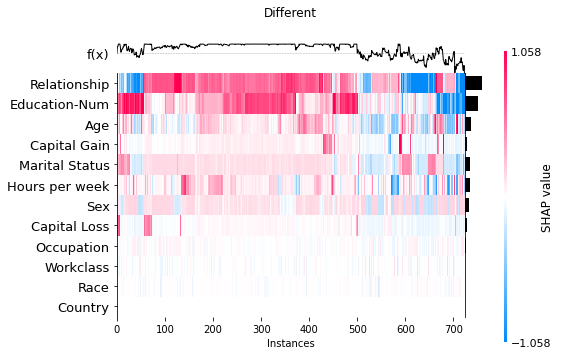

In [44]:
plot.shap_heatmap(shap_log_odds_diff[is_normal], 'Different', feature_order)

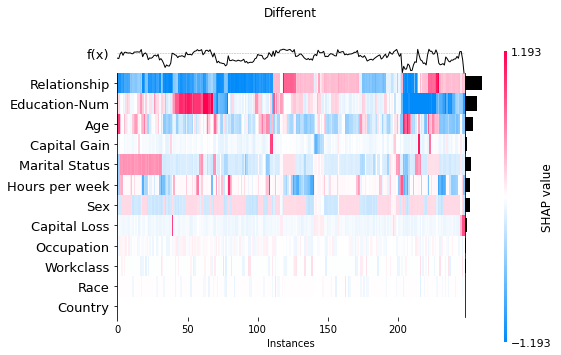

In [45]:
plot.shap_heatmap(shap_log_odds_diff[is_normal & is_low_proba_diff], 'Different', feature_order)

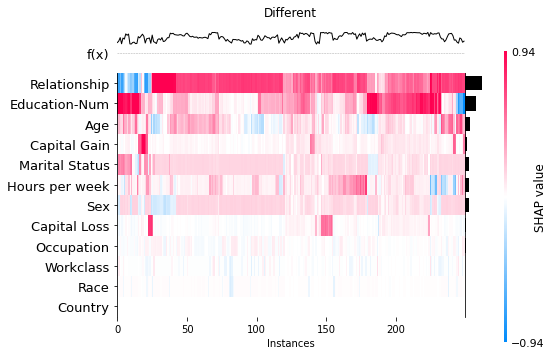

In [46]:
plot.shap_heatmap(shap_log_odds_diff[is_normal & is_high_proba_diff], 'Different', feature_order)

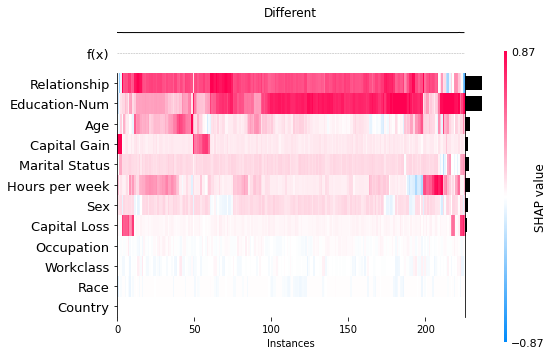

In [47]:
plot.shap_heatmap(shap_log_odds_diff[is_normal & is_pred_diff], 'Different', feature_order)

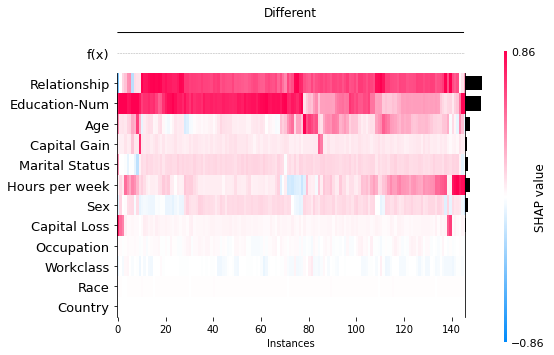

In [48]:
plot.shap_heatmap(shap_log_odds_diff[is_normal & is_pred_diff_a_pos], 'Different', feature_order)

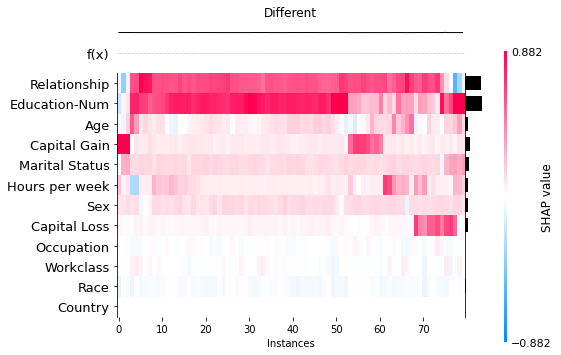

In [49]:
plot.shap_heatmap(shap_log_odds_diff[is_normal & is_pred_diff_b_pos], 'Different', feature_order)

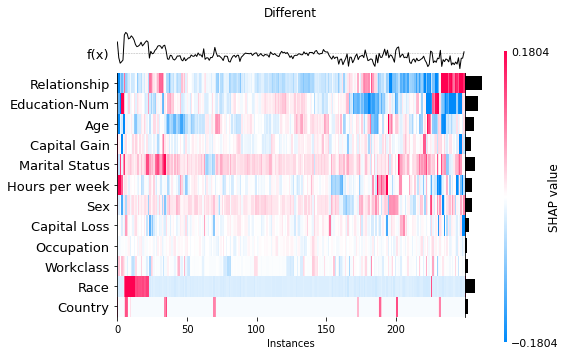

In [50]:
plot.shap_heatmap(shap_log_odds_diff_a_vs_b_pos[is_normal & is_high_proba_diff], 'Different', feature_order)

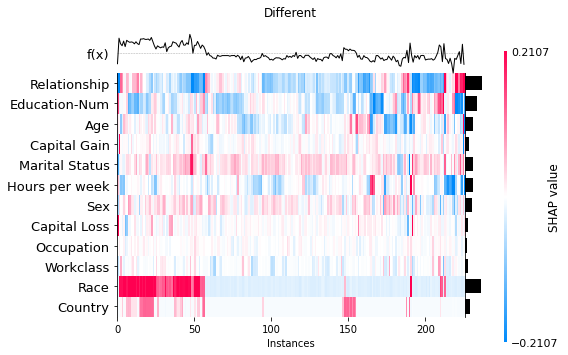

In [51]:
plot.shap_heatmap(shap_log_odds_diff_a_vs_b_pos[is_normal & is_pred_diff], 'Different', feature_order)

### Unusual instances

An unusually high capital gain leads to a very big SHAP value for the instance's feature.

In [61]:
pd.DataFrame(display_data_explain[idx_nonfinite, :], index=idx_nonfinite, columns=feature_names)

,Age,Workclass,Education-Num,Marital Status,Occupation,Relationship,Race,Sex,Capital Gain,Capital Loss,Hours per week,Country


In [60]:
idx_nonfinite = np.where(~is_finite)[0]

In [53]:
pd.DataFrame(display_data_explain[idx_outliers, :], index=idx_outliers, columns=feature_names)

,Age,Workclass,Education-Num,Marital Status,Occupation,Relationship,Race,Sex,Capital Gain,Capital Loss,Hours per week,Country
59,65.0,Self-emp-inc,13.0,Married-civ-spouse,Sales,Husband,White,Male,99999.0,0.0,60.0,United-States
94,52.0,Self-emp-inc,15.0,Married-civ-spouse,Prof-specialty,Husband,White,Male,99999.0,0.0,35.0,United-States


~The `NaN` shap values in Workclass and Relationship seem to be connected to the unusually high capital gain~

In [59]:
for idx in idx_outliers:
    plot.shap_force(shap_log_odds_diff[idx], f'log(odds(different)), instance #{idx}')
    plot.shap_force(shap_log_odds_diff_a_vs_b_pos[idx], f'A vs. B, Instance #{idx}')

#### Non-finite SHAP-values

In [64]:
idx_nonfinite = np.where(~is_finite)[0]

In [65]:
pd.DataFrame(display_data_explain[idx_nonfinite, :], index=idx_nonfinite, columns=feature_names)

,Age,Workclass,Education-Num,Marital Status,Occupation,Relationship,Race,Sex,Capital Gain,Capital Loss,Hours per week,Country


In [66]:
pd.DataFrame(shap_log_odds_diff[idx_nonfinite].values, index=idx_nonfinite, columns=feature_names)

ValueError: Empty data passed with indices specified.

In [ ]:
pd.DataFrame(shap_log_odds_diff_a_vs_b_pos[idx_nonfinite].values, index=idx_nonfinite, columns=feature_names)